In [2]:
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams

rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20
import numpy as np

In [3]:
def log_prob(x, mu, cov):
    diff = x - mu
    return -0.5 * np.dot(diff, np.linalg.solve(cov, diff))
    

In [4]:
ndim = 5

np.random.seed(42)
means = np.random.rand(ndim)

cov = 0.5 - np.random.rand(ndim**2).reshape((ndim, ndim))
cov = np.triu(cov)
cov += cov.T - np.diag(cov.diagonal())
cov = np.dot(cov, cov)

nwalkers = 32
p0 = np.random.rand(nwalkers, ndim)

In [5]:
import emcee

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[means, cov])

In [6]:
state = sampler.run_mcmc(p0, 100)
sampler.reset()

In [7]:
sampler.run_mcmc(state, 10000);

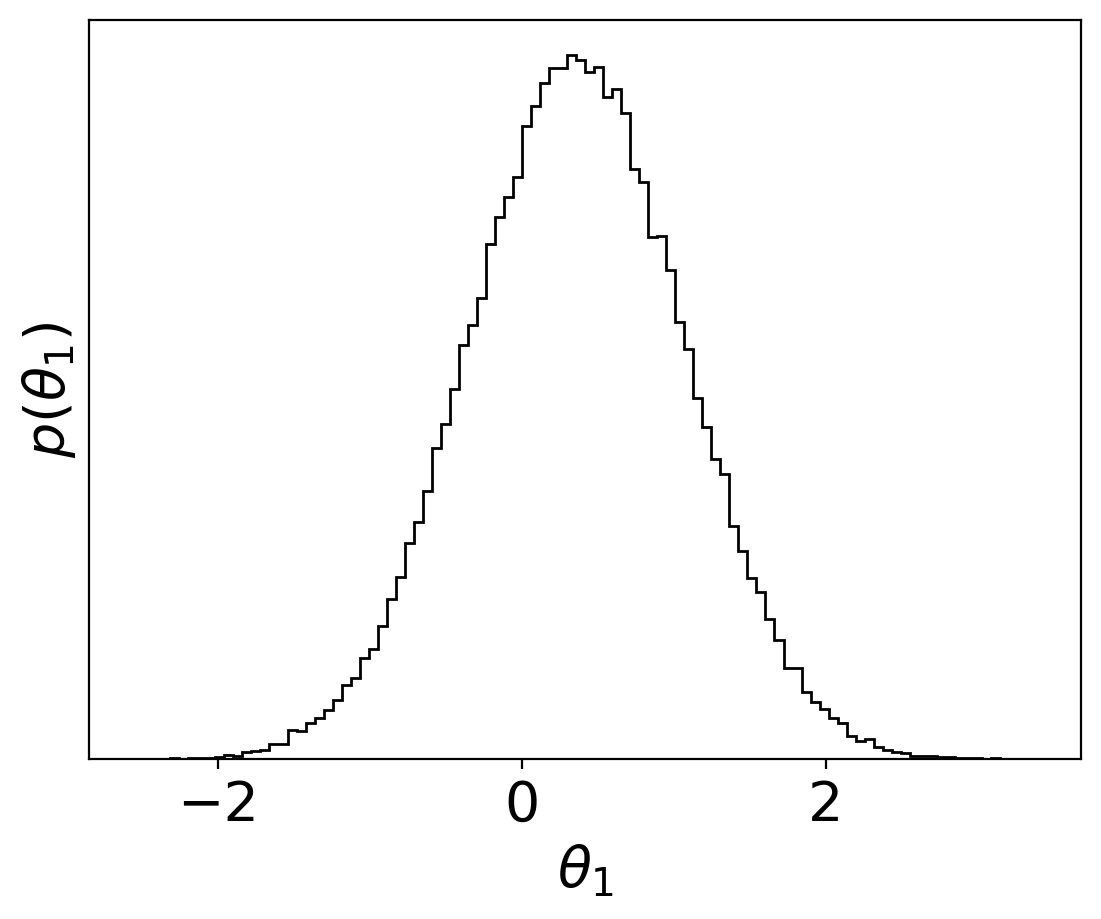

In [14]:
import matplotlib.pyplot as plt

samples = sampler.get_chain(flat=True)
plt.hist(samples[:, 0], 100, color="k", histtype="step")
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$p(\theta_1)$")
plt.gca().set_yticks([]);

In [15]:
print(
    "Mean acceptance fraction: {0:.3f}".format(
        np.mean(sampler.acceptance_fraction)
    )
)
print(
    "Mean autocorrelation time: {0:.3f} steps".format(
        np.mean(sampler.get_autocorr_time())
    )
)

Mean acceptance fraction: 0.552
Mean autocorrelation time: 57.112 steps


In [17]:
info = {
    "likelihood": {
        "gaussian_mixture": {
            "means": [0.2, 0],
            "covs": [[0.1, 0.05],
                     [0.05, 0.2]],
            "derived": True}},
    "params": dict([
        ("a", {
            "prior": {"min": -0.5, "max": 3},
            "latex": r"\alpha"}),
        ("b", {
            "prior": {"dist": "norm", "loc": 0, "scale": 1},
            "ref": 0,
            "proposal": 0.5,
            "latex": r"\beta"}),
        ("derived_a", {
            "latex": r"\alpha^\prime"}),
        ("derived_b", {
            "latex": r"\beta^\prime"})]),
    "sampler": {
        "mcmc": None}}

In [18]:
from cobaya.run import run

updated_info, sampler = run(info)

[mcmc] Getting initial point... (this may take a few seconds)
[prior] Reference values or pdfs for some parameters were not provided. Sampling from the prior instead for those parameters.
[mcmc] Initial point: a:0.4346959, b:0
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {gaussian_mixture: 6070.0}
[prior] *WARNING* Reference pdf not defined or improper for some parameters. Using prior's sigma instead for them.
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Sampling!
[mcmc] Progress @ 2024-01-12 21:03:10 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 80 samples accepted.
[mcmc]  - Acceptance rate: 0.161
[mcmc]  - Convergence of means: R-1 = 0.210629 after 64 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 160 samples accepted.
[mcmc]  - Acceptance rate: 0.

D:\Python\project_cosmology\cospo\lib\site-packages\cobaya\collection.py:651: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  self._data = pd.concat([


[mcmc] Learn + convergence test @ 240 samples accepted.
[mcmc]  - Acceptance rate: 0.279
[mcmc]  - Convergence of means: R-1 = 0.122759 after 192 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 320 samples accepted.
[mcmc]  - Acceptance rate: 0.305
[mcmc]  - Convergence of means: R-1 = 0.080394 after 256 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 400 samples accepted.
[mcmc]  - Acceptance rate: 0.313
[mcmc]  - Convergence of means: R-1 = 0.013682 after 320 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 480 samples accepted.
[mcmc]  - Acceptance rate: 0.307
[mcmc]  - Convergence of means: R-1 = 0.036790 after 384 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 560 samples accepted.
[mcmc]  - Acceptance rate: 0.299
[mcmc]  - Convergence of means: R-1 = 0.032038 after 44

[mcmc] *WARNING* When combining chains, it is recommended to remove some initial fraction, e.g. 'skip_samples=0.3'
[root] *WARNING* outlier fraction 0.11818181818181818 
Mean:
[0.21061117 0.03466911]
Covariance matrix:
[[0.08566028 0.02973914]
 [0.02973914 0.14148439]]


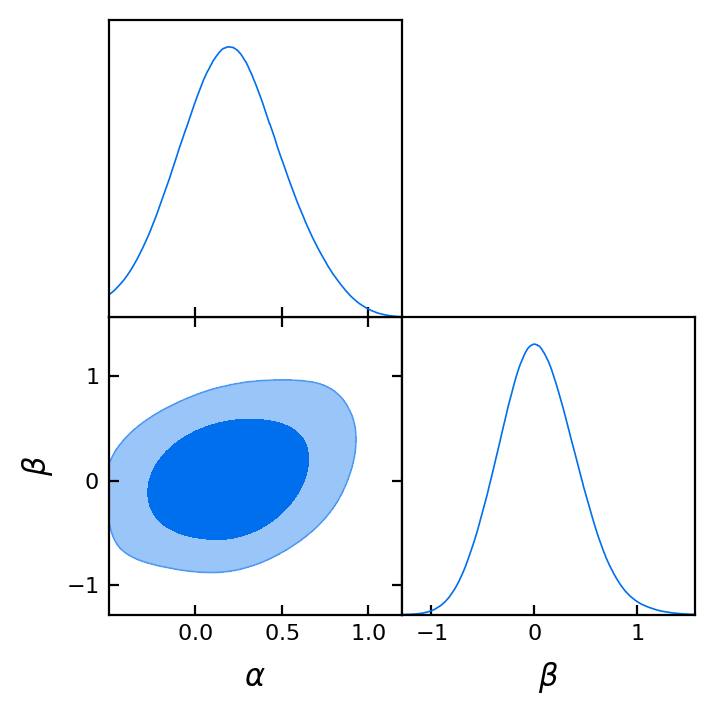

In [19]:
# Export the results to GetDist
gd_sample = sampler.products(to_getdist=True)["sample"]

# Analyze and plot
mean = gd_sample.getMeans()[:2]
covmat = gd_sample.getCovMat().matrix[:2, :2]
print("Mean:")
print(mean)
print("Covariance matrix:")
print(covmat)
# %matplotlib inline  # uncomment if running from the Jupyter notebook
import getdist.plots as gdplt

gdplot = gdplt.get_subplot_plotter()
gdplot.triangle_plot(gd_sample, ["a", "b"], filled=True)

In [28]:
import numpy as np
from scipy import stats


def gauss_ring_logp(x, y, mean_radius=1, std=0.02):
    """
    Defines a gaussian ring likelihood on cartesian coordinater,
    around some ``mean_radius`` and with some ``std``.
    """
    return stats.norm.logpdf(np.sqrt(x**2 + y**2), loc=mean_radius, scale=std)

In [33]:
print(gauss_ring_logp(0.1,0.1))

-750.4899211528292


In [22]:
info = {"likelihood": {"ring": gauss_ring_logp}}
info["params"] = {
    "x": {"prior": {"min": 0, "max": 2}, "ref": 0.5, "proposal": 0.01},
    "y": {"prior": {"min": 0, "max": 2}, "ref": 0.5, "proposal": 0.01}}

In [23]:
def get_r(x, y):
    return np.sqrt(x ** 2 + y ** 2)


def get_theta(x, y):
    return np.arctan(y / x)

info["params"]["r"] = {"derived": get_r}
info["params"]["theta"] = {"derived": get_theta,
                           "latex": r"\theta", "min": 0, "max": np.pi/2}

In [25]:
info["sampler"] = {"mcmc": {"Rminus1_stop": 0.001, "max_tries": 1000}}

from cobaya import run
updated_info, sampler = run(info)

[ring] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[mcmc] Initial point: x:0.5, y:0.5
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {ring: 7320.0}
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Sampling!
[mcmc] Progress @ 2024-01-12 21:07:47 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 80 samples accepted.
[mcmc]  - Acceptance rate: 0.703
[mcmc]  - Convergence of means: R-1 = 9.571176 after 64 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 160 samples accepted.
[mcmc]  - Acceptance rate: 0.520
[mcmc]  - Convergence of means: R-1 = 0.774141 after 128 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 240 samples accepted.
[mcmc]  - Acceptance rate: 0.400

D:\Python\project_cosmology\cospo\lib\site-packages\cobaya\collection.py:651: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  self._data = pd.concat([


[mcmc]  - Acceptance rate: 0.243
[mcmc]  - Convergence of means: R-1 = 0.648969 after 256 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 400 samples accepted.
[mcmc]  - Acceptance rate: 0.197
[mcmc]  - Convergence of means: R-1 = 0.380559 after 320 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 480 samples accepted.
[mcmc]  - Acceptance rate: 0.171
[mcmc]  - Convergence of means: R-1 = 0.225740 after 384 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 560 samples accepted.
[mcmc]  - Acceptance rate: 0.154
[mcmc]  - Convergence of means: R-1 = 0.123743 after 448 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 640 samples accepted.
[mcmc]  - Acceptance rate: 0.148
[mcmc]  - Convergence of means: R-1 = 0.017983 after 512 accepted steps
[mcmc]  - Updated covariance matrix of 

[mcmc] *WARNING* When combining chains, it is recommended to remove some initial fraction, e.g. 'skip_samples=0.3'


(2, 1)

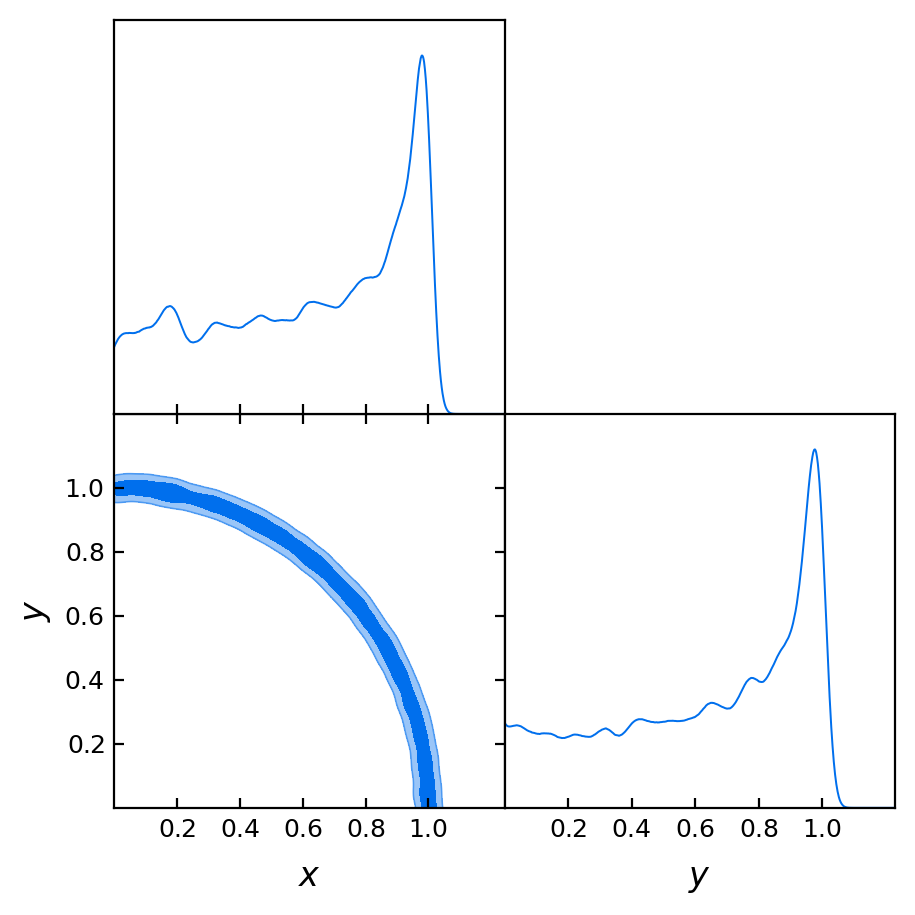

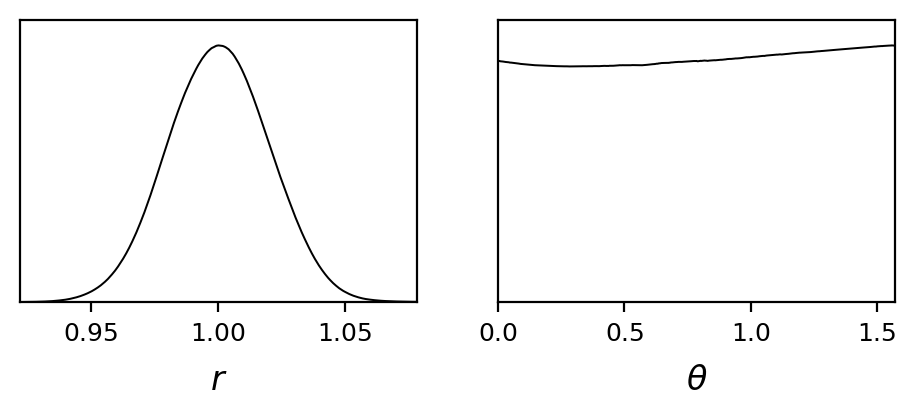

In [26]:
%matplotlib inline
import getdist.plots as gdplt

gdsamples = sampler.products(to_getdist=True)["sample"]
gdplot = gdplt.get_subplot_plotter(width_inch=5)
gdplot.triangle_plot(gdsamples, ["x", "y"], filled=True)
gdplot = gdplt.get_subplot_plotter(width_inch=5)
gdplot.plots_1d(gdsamples, ["r", "theta"], nx=2)